In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.integrate
import scipy.optimize
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Bayesian Statistics

## Counting photons...

Typically, an X-ray imaging observation gives a collection of *events*: coordinates and energies of individual photons detected by the telescope. Essentially, we count photons, and this is why we usually refer to the photons as *counts*, while the *count rate* informs us about the number of photons per second. In general, the count rate scales with the flux of the field (or source) in the energy band of the telescope.

![Chandra observation of NGC 1482 (Vagshette et al. 2011, Proceedings of the 29th Meeting of the Astronomical Society of India)](images/NGC1482.png)

Using *source detection algorithms* we distinguish between different sources and measure their emission. For a given source, the integrated energy of the photons that came from the *source region* gives us an estimate on the energy collected from the telescope. Of course, the response of the detector and absorption effect should be accounted for. Having many counts allows us to fit for the spectrum of the source and measure the *bolometric* flux of the source. Provided we know the distance of the source we can convert from flux to luminosity... an intrinsic property of the source (which is what we usually care for)!

## Estimate the flux of a source

Using the Chandra X-ray Observatory, we found a source that emitted 5 counts in an observation of 1ks of the galaxy NGC 1482. What is the luminosity of the source?

* Using a typical model for the spectrum of an X-ray source (power law with index=1.7), and Galactic absorption $N_{\mathrm{H}}=4.07\times10^{20}\,\mathrm{cm}^{-2}$ (corresponding to the direction of NGC 1482 galaxy) and the characteristics of the telescope, we found that: 1 count/s corresponds to a flux of $2.851\times 10^{-11}$ erg/s/cm$^2$.
* The distance of NGC 1482 is estimated to be 19.6 Mpc.

In [2]:
exposure_time_in_seconds = 1.0e3   # from the duration of the observation
distance_in_Mpc = 19.6             # from literature
counts_to_flux_factor = 2.851e-11  # from X-ray observers' tools (e.g., Chandra PIMMS tool)
counts = 5                         # from source detection


counts_per_second = counts / exposure_time_in_seconds
print(f"Count rate : {counts_per_second:10.3g} count/s")
source_flux = counts_to_flux_factor * counts_per_second
print(f"Source flux: {source_flux:10.3g} erg/s/cm^2")

flux_to_luminosity = 1.19e50 * distance_in_Mpc ** 2.0
source_luminosity = source_flux * flux_to_luminosity

print(f"Luminosity : {source_luminosity:10.3g} erg/s")

Count rate :      0.005 count/s
Source flux:   1.43e-13 erg/s/cm^2
Luminosity :   6.52e+39 erg/s


## What is the uncertainty on this luminosity?

When counting things that are not correlated together, we get a Poisson distribution. If an X-ray source emits on average $\lambda$ photons that can be detected by our telescope during the observation (accounting for absorption, instrumental functions, etc.) then the probability to detect any number of photons is given by the **probability mass function** of the Poisson-distributed random variable $X$ with parameter $\lambda$ (which is also the **expected value** or mean of the Poisson distribution):

$$\large \mathrm{Pois}(k; \lambda) = \dfrac{ \lambda^k e^{-\lambda} }{ k! } $$

$$\large \mu = \mathrm{E}[X] = \sum_{k=0}^{\infty} k \times \mathrm{Pois}(k; \lambda) = \cdots \lambda $$

$$\large \sigma = \sqrt{\mathrm{Var}[X]} = \sqrt{ \mathrm{E}\left[\left(X-\mathrm{E}[X]\right)^2\right] } = \cdots = \sqrt{\lambda} $$

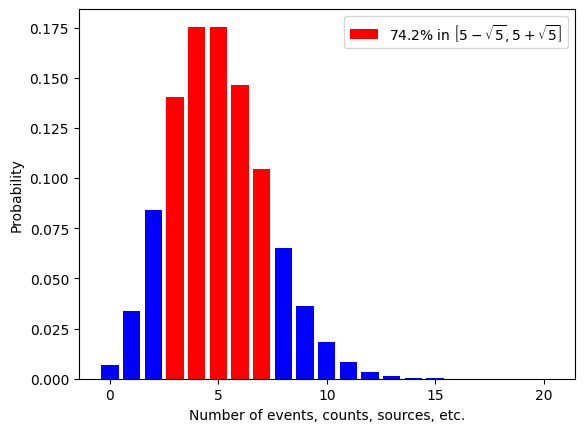

In [4]:
lam = 5.0
k = np.arange(0, 21)
Pk = st.poisson(lam).pmf(k)

in_CI = (k >= lam-lam**0.5) & (k <= lam+lam**0.5)
fraction_in_CI = "{:.1f}%".format(100.0 * sum(Pk[in_CI]))

plt.figure()
plt.bar(k[in_CI], Pk[in_CI], color="r", label=fraction_in_CI+r" in $\left[5-\sqrt{5}, 5+\sqrt{5}\right]$")
plt.bar(k[~in_CI], Pk[~in_CI], color="b")
plt.ylabel("Probability")
plt.xlabel("Number of events, counts, sources, etc.")
plt.legend(loc="upper right")
plt.show()

In [5]:
counts_uncertainty = counts ** 0.5
luminosity_uncertainty = flux_to_luminosity * counts_to_flux_factor * counts_uncertainty / exposure_time_in_seconds
print(f"Uncertainty on luminosity: {luminosity_uncertainty:.3g} erg/s")
print(f"We may report: ({source_luminosity/1.e39:.3g} +/- {luminosity_uncertainty/1.e39:.3g}) x 10^39 erg/s")

Uncertainty on luminosity: 2.91e+39 erg/s
We may report: (6.52 +/- 2.91) x 10^39 erg/s


## Are we using the Poisson nature of the counts the correct way?

The uncertainy is calculated as the square root of the mean value of the Poisson distribution. **But we never observed the mean value**!

> We can get 5 counts if the mean value is 5, but also in the case of a mean value of 3 or 20!

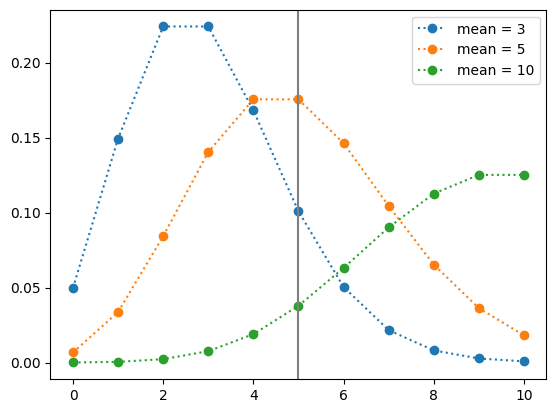

In [10]:
plt.figure()
for mean_value in [3, 5, 10]:
    k = np.arange(11)
    Pk = st.poisson(mean_value).pmf(k)
    plt.plot(k, Pk, "o:", label=f"mean = {mean_value}")
plt.axvline(5, color="0.5")
plt.legend(loc="upper right")
plt.show()

### Can you justify why we use the counts as the mean of the distribution?

Someone could argue that the peak of the distribution is the most probable value, and therefore measuring the latter justifies the inference that the distribution at hand represents the data!

> Many different parameters in a distribution may result in the same peak value!

The peak of Pois(5) is both at 4 and 5! So, if we detected 4 counts, should we have inferred that $\lambda=5$ instead of $\lambda=4$?

Similarily, the peak of Pois(6) is both at 5 and 6!

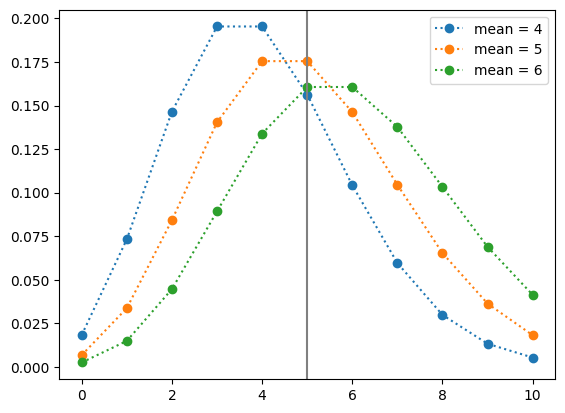

In [14]:
plt.figure()
for mean_value in [4, 5, 6]:
    k = np.arange(11)
    Pk = st.poisson(mean_value).pmf(k)
    plt.plot(k, Pk, "o:", label=f"mean = {mean_value}")
plt.axvline(5, color="0.5")
plt.legend(loc="upper right")
plt.show()

## ... and all these refer the Poissons with integer $\lambda$!

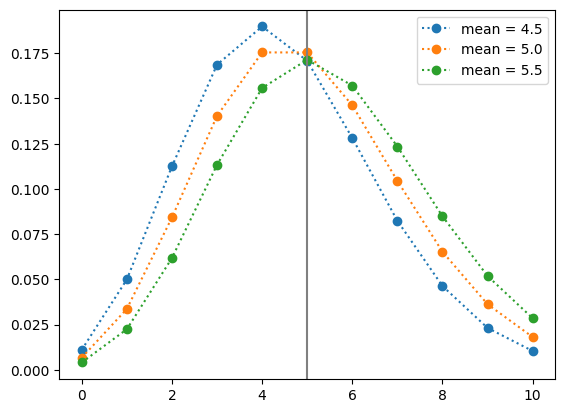

In [17]:
plt.figure()
for mean_value in [4.5, 5.0, 5.5]:
    k = np.arange(11)
    Pk = st.poisson(mean_value).pmf(k)
    plt.plot(k, Pk, "o:", label=f"mean = {mean_value}")
plt.axvline(5, color="0.5")
plt.legend(loc="upper right")
plt.show()

### We used the frequentist (or classic) approach. What about Bayesian statistics?

> A frequentist assigns probabilities to data

We did the above analysis assuming the source counts are equal to the detected ones, and assigned probabilities to different data outcomes. Our inference on the source luminosity and its uncertainty is telling us that if we got a good estimate from the observation, *repeating the experiment many times* we will find the above variation in the luminosity.

**However, we have no indication that the source will continue shining! The "repition" part of the frequentist interpretation is often unrealistic!**

> A Bayesianist assigns probabilities to hypotheses

- The data is not a random variable. We made a measurement and we know it with absolute certainty. Instead, we want to understand the physical processes producing the data we got.
- Knowing the result from repeating the experiment is very specific: maybe we care about what was the luminosity at that given period of time. This is not a repeatable situation!

![image from Sivia](images/Sivia_Logic.png)

The intrinsic source luminosity (and therefore the expected counts) is unknown and we want to infer it from the data. Therefore we ask: what is the probability that our source has an average count $\lambda$ given the data (detected number of counts) for all possible values of $\lambda$ (or hypotheses)?

$$\large P(\lambda | k) = \mathrm{?}$$

## Probability calculus

How do we begin to calculate the above probability?

When we are dealing with probabilties, there are useful notations and rules:

> MOVE items to later but summarize at the end

$ P(A) $ is the probability of an event/hypothesis $A$ to be true, a number between 0 and 1.

$$\large P(\text{tails}) = 0.5 $$

$ P(\bar{A})$ is the probability that $A$ is not true, and it is equal to $1-P(A)$.

$$\large P(\text{not tails}) = 1 - P(\text{tails}) = 0.5 $$

$ P(A, B) $ is the **joint** probability that $A$ and $B$ are both true. Of course $P(A, B) = P(B, A)$

$$\large P(\text{tails after tossing a coin}) = P(\text{the coin was tossed}, \text{tails}) = 0.5 $$

$ P(A | B)$ is the conditional probability: $A$ to be true if $B$ is true, or **A given B**.

$$\large P(\text{tails} | \text{the die was cast}) = 0.5 $$

$P(A, B) = P(A | B) P(B) $ is the chain rule.

We throw two coins...
$$\large P(\text{heads from 1st}, \text{heads from 2nd}) = P(\text{heads from 1st} | \text{heads from 2nd}) \times P(\text{heads from 2nd}) = 0.5 \times 0.5 = 0.25 $$
(where we assumed that the tossings are independent).

We have two coins. We throw the first, and if the result is tails, we are allowed to throw the next one.

$$\large P(\text{heads from 1st}, \text{heads from 2nd}) = P(\text{heads from 2nd} | \text{heads from 1st}) \times P(\text{heads from 1st}) = 0 \times 0.5 = 0 $$

## Bayes' theorem, law or rule

Applying the chain rule we have two way to write the probability of two events:

$$\large P(A, B) = P(A | B) P(B) $$
$$\large P(B, A) = P(B | A) P(A) $$

By equalizing the right-hand sides we get:

$$\large P(A | B) = \dfrac{ P(B|A) P(A) }{ P(B) } $$

So in data analysis we can characterize the belief in a hypothesis using data in the following way:

$$\large P(\text{hypothesis} | \text{data}, I ) = \dfrac{ P(\text{data | hypothesis}, I) P(\text{hypothesis} | I)}{ P(\text{data} | I) } $$

The symbol $I$ denotes the **background information**: all relevant knowledge we have about the problem we are solving. 

For example, if we are testing whether a dice is fair, the data are a sequence of outcomes (e.g., 1, 6, 3, 5, 3, 1), the hypothesis is **it's a fair dice**, and $I$ is {the dice has 6 sides, a fair dice has equiprobable sides, the Moon is not made of cheese, ...}

For brevity, **we usually omit writing the $I$** in the equations, but **it's always there**... somewhere in the background!

All the terms of this equation, the famous Bayes' rule, have names:

* **Posterior**: $P(\text{hypothesis} | \text{data}, I)$ is the degree of belief we have on the hypothesis after (a posteriori) looking at the data
* **Likelihood**: $P(\text{data | hypothesis}, I)$ is the likelihood of collecting the data at hand, given that the hypothesis is true (what a frequentist would look at)
* **Prior**: $P(\text{hypothesis} | I)$ is the degree of belief in the hypothesis before looking at the data (a priori). E.g., from previous studies, mathematical or physical constraints, ...
* **Evidence**: $P(\text{data} | I)$ is the probability of getting the data independently of whether the hypothesis is true or false. We almost never know the evidence and in most problems its value is not affecting the analysis!

## A Bayesian approach to our problem

$$\large 
P(\lambda | k) = 
\dfrac{ \large P(k | \lambda) P(\lambda) }{ P(k) }
$$

*(for brevitiy we omitted the conditional term $I$)*

### Constructing the likelihood

The likelihood is expressed as the PDF of the Poisson with expected value the unknown parameter $\lambda$:

$$\large
P(k | \lambda) = \text{Pois}(k; \lambda) = \dfrac{\lambda^k e^{-\lambda}}{k!}
$$

*(usually words like Pois, Norm, Gamma, etc. describe distributions. Using the Dist(x; p) notation we are referring to the probability mass function (discrete distirbutions) or the probability density function (continuous distributions) with parameters $p$ evaluated at $x$)*

Let's look at it...

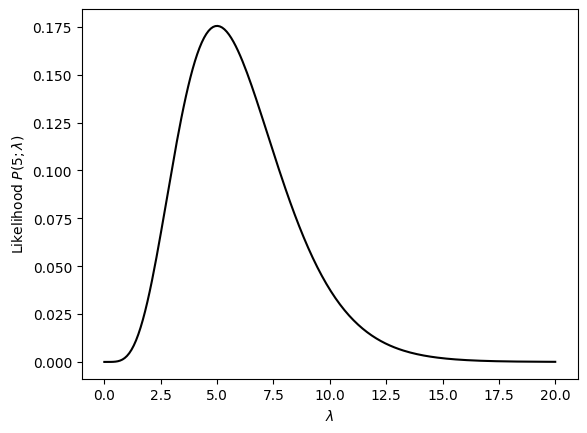

In [5]:
lambdas = np.linspace(0.0, 20, 200)
k = counts

likelihoods = st.poisson.pmf(k, lambdas)

plt.figure()
plt.plot(lambdas, likelihoods, "k-")
plt.xlabel("$\lambda$")
plt.ylabel("Likelihood $P(5; \lambda)$")
plt.show()

This is not a Poisson distribution, since the "random variable" is now $\lambda$ and it is continuous (Poisson is a *discrete* distribution)! In reality this is the **Gamma distribution** with shape parameter $\kappa=k+1$ and scale parameter $\theta=1$.

### Constructing the prior

What about the prior? If we have no previous information about the source, the we could be agnostic and consider all different values as equal:

$$\large  P(\lambda) = \text{a positive constant}, \quad \lambda \in \mathbb{R} $$ 

Constant priors of an infinite or finite range are called **uniform priors**. However this is not an actual probability density function, since it's integration over the whole range $\lambda \in \left(-\infty, \infty\right)$ would lead to infinity. We could take a safe, huge, but finite range. At the end of the day, it doesn't make any difference, so we often use these **improper priors**.

In our case we can do better by requiring the $\lambda$ is positive since our source luminosity cannot be negative!

$$\large  P(\lambda) = A \begin{cases} 1, \quad \lambda \geq 0 \\ 0, \quad \lambda < 0 \end{cases} $$

Note that this is still an **imporper prior**. We can even omit the normalization factor $A$ since we cannot rescale an improper prior.

But to do things properly... we can assume a uniform distribution. Maybe previous studies showed that point sources in galaxies have an upper limit in the luminosity, which in our observation corresponds to 10 counts.

$$\large  P(\lambda) = A \begin{cases} 1, \quad \lambda \in [0, 10] \\ 0, \quad \text{elsewhere} \end{cases} $$

Properly normalizing the prior results in:

$$\large \int_{-\infty}^{\infty} P(\lambda) d\lambda = \int_{0}^{10} A d\lambda = 1 \Rightarrow A = \frac{1}{10} $$

### The evidence

The term $ P(k)$ is called *evidence*, or marginal likelihood. It describes the probability of getting the data given the background information, but regardless of the parameters of the models (or the hypotheses). In the theory example, this is:

$$\large P(\text{data}) = P(\text{data | hypothesis}) P(\text{hypothesis}) + P(\text{data} | \overline{\text{hypothesis}}) P(\overline{\text{hypothesis}}) $$

Therefore, it is the summation of the likelihood of the data considering all possible outcomes of the experiment. In the case that we are calculating the posterior for a model parameter, say, the number of lines in a spectrum we would have a posterior looking like this:

$$\large P(\text{num. of lines | spectrum}) = \dfrac{ P(\text{spectrum | num. of lines}) P(\text{num. of lines}) }
   { P(\text{spectrum}) } $$
   
with the evidence being:

$$\large P(\text{spectrum}) = P(\text{spectrum | no lines}) P(\text{no lines}) + P(\text{spectrum | one line}) P(\text{one line}) + \cdots = \sum_{n=0}^{\infty} P(\text{spectrum | num. of lines = n}) P(\text{num. of lines = n}) $$

Notice, that we are practically integrating, or **marginalizing** the numerator of the Bayes formula, hence, normalizing the probabilities. Notice, however, that since the evidence does not depend on the hypothesis, when calculating the **relative** probabilities of the different number of lines, it is a constant. **This is why in most problems we ignore this term, and only if necessary, we calculate it to normalize the posterior.** When selecting between hypothesis, or different models, the evidence may be imporant.

In our source photon problem the evidence is
$$\large P(k) = \int_{-\infty}^{\infty} P(k | \lambda) P(\lambda) d\lambda $$
which just normalizes the numerator, and we can ignore it.


### How the posterior looks now...

$$\large 
P(\lambda | k) = 
    \begin{cases}
        \dfrac{\lambda^k e^{-\lambda}}{k!} \times \frac{1}{15} \times \dfrac{1}{\text{evidence}} &,\quad \lambda \in [0, 10]
\\
        0 & ,\quad \text{elsewhere}
    \end{cases}
$$

Since we ignore the normalization from the evidence, it doesn't make sence to keep the normalization of the prior. Any uniform prior can be neglected, but we should make sure we are respecting the bounds of the priors (if any)! Therefore,

$$\large 
P(\lambda | k) \propto 
    \begin{cases}
        \dfrac{\lambda^k e^{-\lambda}}{k!} &,\quad \lambda \in [0, 10]
\\
        0 &,\quad \text{elsewhere}
    \end{cases}
$$

Notice that this is very similar to the likelihood a frequentist uses. The only difference is that we are now estimating $\lambda$, taking into account prior information. 

Most importantly, while writing down the equations, we had to consider all terms and think about our assumptions, background information, etc.

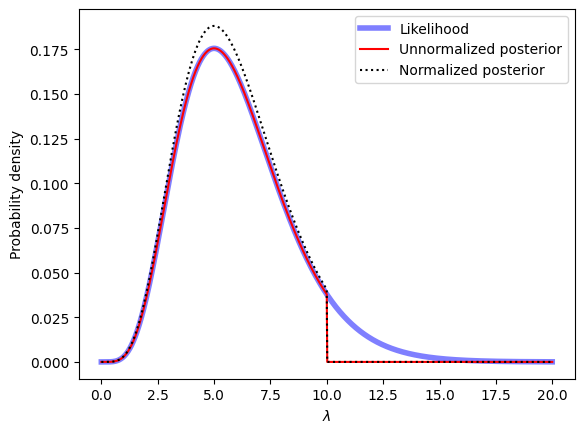

In [21]:
def prior(lam):
    if lam < 0 or lam > 10:
        return 0.0
    return 1.0

def likelihood(k, lam):
    return st.poisson(lam).pmf(k)

def posterior(lam, k):
    return likelihood(k, lam) * prior(lam)

lambdas = np.linspace(0.0, 20, 1001)
likelihoods = st.poisson.pmf(counts, lambdas)
posteriors = np.array([posterior(lam, counts) for lam in lambdas])

normalized_posteriors = posteriors / np.trapz(posteriors, lambdas)


plt.figure()
plt.plot(lambdas, likelihoods, color="b", ls="-", lw=4, alpha=0.5, label="Likelihood")
plt.plot(lambdas, posteriors, "r-", label="Unnormalized posterior")
plt.plot(lambdas, normalized_posteriors, "k:", label="Normalized posterior")
plt.xlabel("$\lambda$")
plt.ylabel("Probability density")
plt.legend(loc="upper right")
plt.show()

In [24]:
def calculate_mode_mean_and_std(x, Px):
    mode = x[np.argmax(Px)]
    mean = sum(x * Px) / sum(Px)
    variance = sum((x - mean) ** 2.0 * Px) / sum(Px)
    return mode, mean, variance ** 0.5

mode, mean, std = calculate_mode_mean_and_std(lambdas, likelihoods)
print(f"(usingl only the likelihood)   mode = {mode:.2f} | mean +/- std = {mean:.2f} +/- {std:.2f}")
mode, mean, std = calculate_mode_mean_and_std(lambdas, posteriors)
print(f"(unnormalized posterior)       mode = {mode:.2f} | mean +/- std = {mean:.2f} +/- {std:.2f}")
mode, mean, std = calculate_mode_mean_and_std(lambdas, normalized_posteriors)
print(f"(normalized   posterior)       mode = {mode:.2f} | mean +/- std = {mean:.2f} +/- {std:.2f}")

(usingl only the likelihood)   mode = 5.00 | mean +/- std = 6.00 +/- 2.45
(unnormalized posterior)       mode = 5.00 | mean +/- std = 5.60 +/- 1.95
(normalized   posterior)       mode = 5.00 | mean +/- std = 5.60 +/- 1.95


Notes:
> The prior alters the shape of the posterior and makes it different from the likelihood. A "strict" or informative prior will dominate the final result, while a "loose" or uniformative prior will have negligible effect.
> Using a uniform prior possibly affects the bounds and the normalization, but the maximum a posteriori values might be the same as the maximum likelihood.

### Is the mean value of $\lambda$ the same as if we only used the likelihood?

### Is the uncertainty affected by the prior?

### Does the normalization of the posterior affect the result? 

### Form a question where the result depends on whether we normalized the posterior or not.

# Measuring a source luminosity in the presence of background

In our X-ray image we see that there a detected photons all over the place. These may come from the detector (instrumental background) or foreground (stars in Mikly Way) or background (distant quasars) sources. If we are interested in the luminosity of a source in NGC 1482, we want to correct for the "background". Previous studies have measured the flux or photon counts per unit area, in the bandwidth of our observation. The source detection algorithm that gave as the 5 counts, also found the "source region" and based on its area, we find that we expect on average $\beta=3$ counts from the background!

In [26]:
beta = 3

## How many are the source counts $n$ if we measured $k$ counts and expect $\beta$ counts?

### Method 1: Simply substract the background and assume Poisson distribution

In [27]:
n = counts - beta
n_err = n ** 0.5
print(f"Source counts: {n:.2g} +/- {n_err:.2f}")

Source counts: 2 +/- 1.41


Is the above statement correct? What if:
* the background level was higher than the detected sources? Are the source counts definitely 0? If not, is there an uncertainty?
* What is the probability that there is no count from a source?

In [28]:
print("Probability for at least one source count: {:.2f}".format(1.0 - st.poisson.pmf(0, n)))

Probability for at least one source count: 0.86


### Method 2: The mean background, is a... mean. Take into account the Poisson nature of it...

In [29]:
counts_err = 0.0   # the counts we got are fixed
beta_err = beta ** 0.5

n = counts - beta
n_err = (counts_err ** 2.0 + beta_err ** 0.5) ** 0.5
print(f"Source counts: {n:.2g} +/- {n_err:.2f}")

Source counts: 2 +/- 1.15


Now the probability distribution of the source counts is not Poisson. The uncertainty comes from applying the one-term approximation of the error-propagation formula (which furthermore assumes Gaussian distributions).

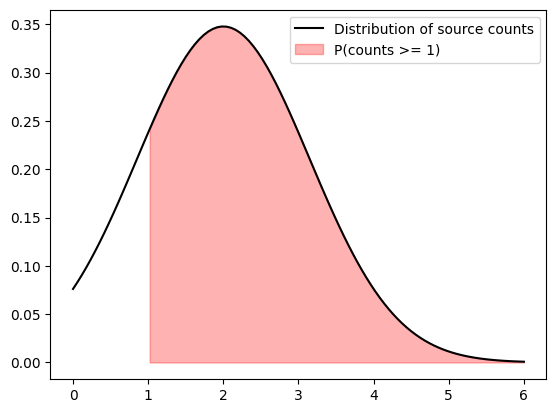

Probability for at least one source count: 0.81


In [30]:
dist = st.norm(n, n_err)
xx = np.linspace(0, 6, 101)
pdf = dist.pdf(xx)
filled = xx >= 1.0
plt.figure()
plt.plot(xx, pdf, "k-", label="Distribution of source counts")
plt.fill_between(xx[filled], 0.0, pdf[filled], color="r", alpha=0.3, label="P(counts >= 1)")
plt.legend(loc="upper right")
plt.show()
print("Probability for at least one source count: {:.2f}".format(1.0 - st.norm.cdf(1, n, n_err)))

Are there any issues about this approach?
* The distribution is now continuous, but we are interested in counts! Does really 0.99 correspond to 0?
* The distribution allows negative values! Should we truncate and renormalize?

In [31]:
probability_after_truncation = (1.0 - st.norm.cdf(1, n, n_err)) / (1.0 - st.norm.cdf(0, n, n_err))
print(f"Probability for at least one source count: {probability_after_truncation:.2f}")

Probability for at least one source count: 0.84


* Both in Method 1 and 2, what if the expected background counts was 2.9? The source counts would be 2.1. This looks likes a mean value, but we are not treated it as such!

### Method 3: A consistent, and frequentistic approach

The probability of having no counts from the source, is the probability that they all detected counts come from the background. The probability of one source count = 4 counts from the background, and so on.

$$\large P(n | k , \beta) = \text{Pois}(k - n; \beta) $$

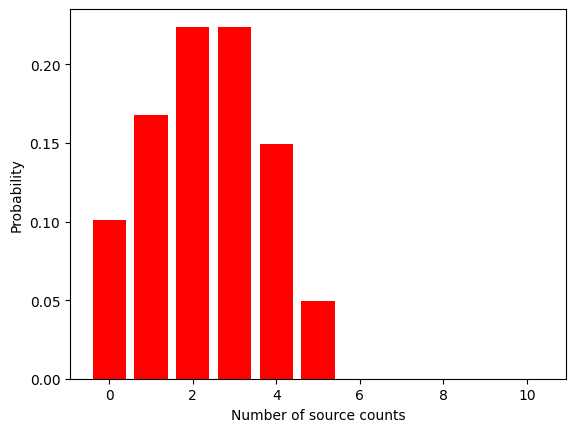

In [14]:
beta = 3.0
n = np.arange(0, 11)
Pn = st.poisson(beta).pmf(counts - n)

plt.figure()
plt.bar(n, Pn, color="r")
plt.ylabel("Probability")
plt.xlabel("Number of source counts")
plt.show()

In [15]:
mode, mean, std = calculate_mode_mean_and_std(n, Pn)
print(f"mode = {mode:.2f} | mean +/- std = {mean:.2f} +/- {std:.2f}")

mode = 2.00 | mean +/- std = 2.33 +/- 1.38


What is the problem with this approach? By accounting for the information on the background, and its Poissonian nature, we are able to quantify the likelihood of a given number of counts coming from a source. However, we never took into account the Poissonian nature of the source counts.

## The Bayesian approach

We detect $k$ counts, out of which $n$ are coming from a source with $\lambda$ counts on average, and $b$ counts from the background with mean level $\beta$. Both the souce and the background counts are Poisson distributed:

$$ \large
\begin{align}
k &= n + b \\
n &\sim \text{Pois}(\lambda) \\
b &\sim \text{Pois}(\beta)
\end{align}
$$

Given we have a measurement of $k$ and $\beta$ (from a previous study), we want to know the $\lambda$. We use the Bayes' rule (neglecting evidence) to quantify the posterior on $\lambda$:

$$\large P(\lambda | k, \beta) \propto P(k | \lambda, \beta) P(\lambda | \beta) $$

The **likelihood** requires the knowledge of what is the number of total counts given the mean source and backgroud counts. In this case we are lucky: the sum of Poisson random variables is a new Poisson variable with mean value equal to the sum of the mean values of the original Poisson variables:

$$ \large k \sim \text{Pois}(\lambda + \beta) $$

and therefore

$$ \large P(k | \lambda, \beta) = \text{Pois}(k; \lambda + \beta) = \text{Pois}(k; \lambda + 3)$$

(the last part comes from the fact that we assume infinite accuracy on $\beta$.

For the **prior** on $\lambda$ we select the improper prior that allows only non-negative values, and therefore

$$\large 
P(\lambda | k, \beta) \propto 
    \begin{cases} 
        \text{Pois}(k; \lambda + 3), &\lambda \geq 0 \\
        0, &\lambda < 0 
    \end{cases}
$$

Let's look at it!

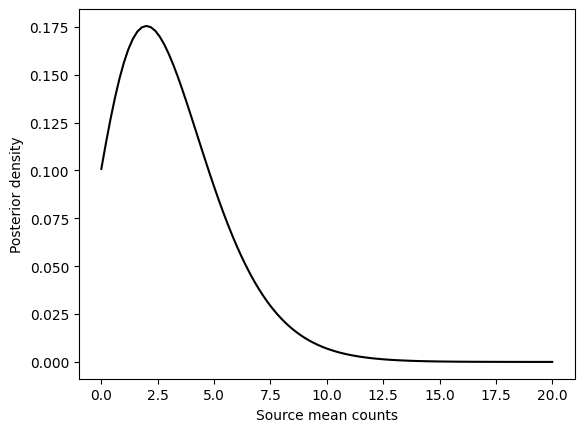

In [16]:
def likelihood(total_counts, source_mean, bkg_mean):
    return st.poisson(source_mean + bkg_mean).pmf(total_counts)

def prior(source_mean):
    return 0.0 if source_mean < 0 else 1.0

def posterior(source_mean, total_counts, bkg_mean):
    return likelihood(total_counts=total_counts, source_mean=source_mean, bkg_mean=bkg_mean) * prior(source_mean)

lambdas = np.linspace(0.0, 20.0, 101)
posteriors_fixedbkg = np.array([posterior(source_mean=lam, total_counts=counts, bkg_mean=beta) for lam in lambdas])

plt.figure()
plt.plot(lambdas, posteriors_fixedbkg, "k-")
plt.xlabel("Source mean counts")
plt.ylabel("Posterior density")
plt.show()

In [17]:
mode, mean, std = calculate_mode_mean_and_std(lambdas, posteriors_fixedbkg)
print(f"mode = {mode:.2f} | mean +/- std = {mean:.2f} +/- {std:.2f}")

mode = 2.00 | mean +/- std = 3.29 +/- 2.30


* Using the Bayesian interpretation of probability we quantified the likelihood of having a source of a given intensity.
* We took into account all information: Poissonian nature of both source and background counts
* We were allowed to apply constraints from previous studies (in the prior)
* The result look as it is expected: it is defined only for non-negative values, peaks close to 0 as we would expect from a weak detection, but gives a small but non-zero probability of a powerful source (no upper limit)!

# Using uncertainties in the background

The mean background level of $3$ was just an example. In reality, we would have a value with an uncertainty coming from the literature. Let's assume it's $3 \pm 1.0$.

What is the posterior now? The background level $\beta$ cannot be treated as background information. It is not a fact, but a parameter for which we do not have absolute knowledge. Consequently, we have to consider all posibilities for the mean source and background counts.

$$\large P(\lambda, \beta | k) \propto P(k | \lambda, \beta) P(\lambda, \beta)$$

The likelihood is still as in the previous example:

$$ \large P(k | \lambda, \beta) = \text{Pois}(k; \lambda + \beta)$$

The prior however is not a *joint prior*, depending on both the source and background levels. Let's use factorization to break it in simpler terms:

$$\large P(\lambda, \beta) = P(\lambda | \beta) P(\beta) $$


(*Note that we could write it as $P(\lambda, \beta) = P(\beta | \lambda) P(\lambda) $, but the following analysis doesn't change!*)

The first term is quantifying the prior on $\lambda$ but given the value of $\beta$, taking into account any possible correlation between our parameters. In our case, we have no reason to believe they are correlated: what a source in our galaxy does shouldn't depend on source in the Milky Way or the distant Universe. Consequently, $P(\lambda | \beta) = P(\lambda)$, and:

$$\large P(\lambda, \beta) = P(\lambda) P(\beta) $$

We can use the same prior on $\lambda$ as before (uniform for $\lambda \geq 0$). For the $\beta$ we use the literature:

$$\large P(\beta) = \text{Norm}(\beta; \mu=3, \sigma=0.3) $$

Consequently, the two-dimensional posterior on both $\lambda$ and $\beta$ is

$$\large 
P(\lambda, \beta | k) \propto 
    \begin{cases} 
        \text{Pois}(k; \lambda + \beta) \times \text{Norm}(\beta; \mu=3, \sigma=0.3), &\lambda \geq 0 \\
        0, &\lambda < 0 
    \end{cases}
$$

The background level $\beta$ might be unknown but we are not specifically interested in its value. We only care about the source level $\lambda$. A quantity that we are not interested in but has to enter the Bayesian analysis is a **nuisance parameter**. To infer the quantities of interest, we use marginalization by integrating over all possible values for the nuisance parameter (or summation when it is discrete):

$$\large 
P(\lambda | k) = \int_{-\infty}^{\infty} P(\lambda, \beta | k) d\beta
$$

Of course, we should integrate from 0 and on, because $\beta$ cannot be negative (effectively, we are truncating the normal distribution).

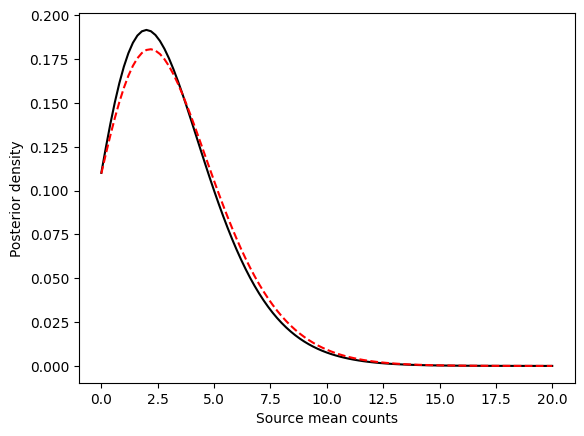

In [18]:
beta = 3.0
beta_err = 1.0

def likelihood(total_counts, source_mean, bkg_mean):
    return st.poisson.pmf(total_counts, source_mean + bkg_mean)

def prior_source(source_mean):
    return 0.0 if source_mean < 0 else 1.0

def prior_background(bkg_mean):
    return st.norm.pdf(bkg_mean, beta, beta_err)

def joint_posterior(source_mean, total_counts, bkg_mean):
    return (likelihood(total_counts=total_counts, source_mean=source_mean, bkg_mean=bkg_mean) 
            * prior_source(source_mean) * prior_background(bkg_mean))

def posterior(source_mean, total_counts):
    result = scipy.integrate.quad(
        lambda bkg: joint_posterior(source_mean=source_mean, total_counts=total_counts, bkg_mean=bkg),
        a=max(0, beta-beta_err*5),
        b=beta+beta_err*5,
    )
    return result[0]

lambdas = np.linspace(0.0, 20.0, 101)
posteriors_varbkg = np.array([posterior(source_mean=lam, total_counts=counts) for lam in lambdas])

plt.figure()
# plt.plot(lambdas, posteriors_fixedbkg, "k-")
# plt.plot(lambdas, posteriors_varbkg, "r--")
plt.plot(lambdas, posteriors_fixedbkg / np.trapz(posteriors_fixedbkg, x=lambdas), "k-")
plt.plot(lambdas, posteriors_varbkg / np.trapz(posteriors_varbkg, x=lambdas), "r--")
plt.xlabel("Source mean counts")
plt.ylabel("Posterior density")
plt.show()

In [19]:
mode, mean, std = calculate_mode_mean_and_std(lambdas, posteriors_varbkg)
print(f"mode = {mode:.2f} | mean +/- std = {mean:.2f} +/- {std:.2f}")

mode = 2.20 | mean +/- std = 3.45 +/- 2.39


# Parameter estimation

The posterior density contains all the information we might need about a parameter given the experimental data and any prior information. However, we often want to report **point estimates**, **best values**, or **confidence intervals**.

Point estimates might be the **mode** (or where the maximum is), or the **mean** which takes into account the shape of the distribution.

In lin-space: y = 10.28 x - 1.87
In log-space: y = 8.666 x ^ 1.062
The fraction: y = 10.01


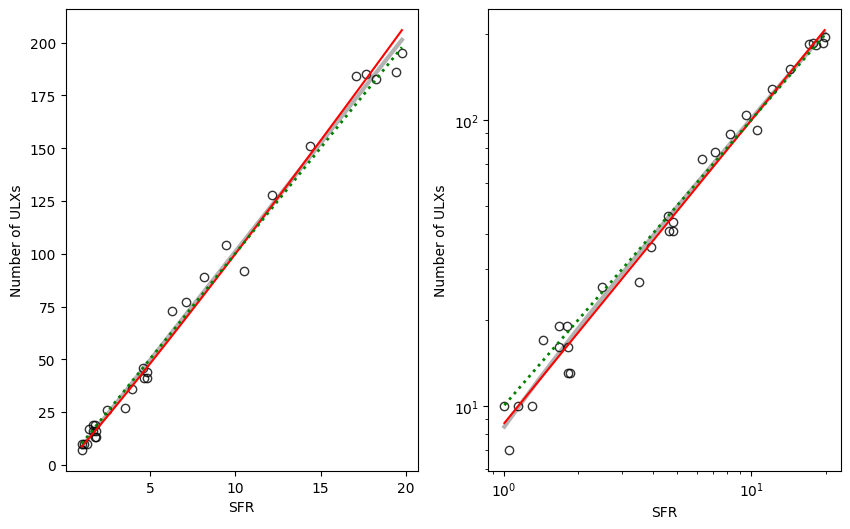

In [242]:
n_galaxies = 30
SFRs = 10.0 ** np.random.uniform(0, 1.3, size=n_galaxies)
a_true = 10.0          # change with 0.5... what is the problem with the fit in log-space?
n_ULXs = np.random.poisson(a_true * SFRs)

slope, interc = np.polyfit(x=SFRs, y=n_ULXs, deg=1)
slope_log, interc_log = np.polyfit(x=np.log10(SFRs), y=np.log10(n_ULXs), deg=1)
slope_mle = sum(n_ULXs) / sum(SFRs)

xx = np.linspace(min(SFRs), max(SFRs), 100)
yy = slope * xx + interc
yy_log = 10.0 ** (slope_log * np.log10(xx) + interc_log)
yy_mle = slope_mle * xx

sign = "+" if interc >= 0 else "-"

print(f"In lin-space: y = {slope:.4g} x {sign} {abs(interc):.4g}")
print(f"In log-space: y = {10.0**interc_log:.4g} x ^ {slope_log:.4g}")
print(f"The fraction: y = {slope_mle:.4g}")

# slope_gau = sum(n_XRBs*SFRs) / sum(SFRs**2.0)
# yy_gau = slope_gau * xx

plt.figure(figsize=(10, 6))
for inlog, subplot in zip([False, True], [1, 2]):
    plt.subplot(1, 2, subplot)
    plt.plot(SFRs, n_ULXs, "ko", mfc="None", alpha=0.8)
    plt.plot(xx, yy, "k-", lw=3, alpha=0.3)
    plt.plot(xx, yy_log, "r-")
    plt.plot(xx, yy_mle, "g:", lw=2)
# plt.plot(xx, yy_gau, "m--")
    plt.xlabel("SFR")
    plt.ylabel("Number of ULXs")
    if inlog:
        plt.loglog()
plt.show()

We have measurements of the number of ULXs, 
$$\large \{n_i\} = \{n_1, n_2, \cdots, n_N\}$$
and the star-formation rates 
$$\large \{s_i\} = \{s_1, s_2, \cdots, s_N\}$$
for $N$ galaxies.

We expect them to scale with $a$ as the scaling factor and we want to find its value. 

$$\large n_i \approx a s_i $$

However, it is not an equality because in reality, the number of XRBs is Poisson-distributed. The expression could only connect the average number of XRBs in a galaxy as a function of its SFR. The observed value is just following this distribution (if our model is correct):

$$\large n_i \sim \text{Pois}(a s_i) $$

Then the posterior of the scaling factor is:

$$\large 
\begin{align}
        & P(\text{parameters} | \text{data}) = &\quad\text{(for our problem...)}
    \\ =& P(a | \{n_i\} \{s_i\}) = &\quad \text{(apply Bayes' formula)}
    \\ =& P(\{n_i\} | a, \{s_i\}) P(a) = &\quad \text{(break it down to all data/param.)}
    \\ =& P(n_1, n_2, n_3, \cdots n_N | a, s_1, s_2, s_3, \cdots s_N) P(a) &\quad \text{(assume independent data)}
    \\ =& \left[P(n_1 | a, s_1, s_2, s_3, \cdots s_N) \times P(n_2 | a, s_1, s_2, s_3, \cdots s_N) \cdots \right] P(a) = &\quad\text{(but $n_{i\neq j}$ doesn't depend on $s_j$)}
    \\ =& \left[P(n_1 | a, s_1) \times P(n_2 | a, s_2) \cdots P(n_N | a, s_N) \right] P(a) = &\quad\text{(a product of likelihoods...)}
    \\ =& P(a) \prod_{i=1}^{N} P(n_i | a, s_i) = P(a) \prod_{i=1}^{N} L_i
\end{align}
$$

where 

$$\large
L_i = P(n_i | a, s_i)
$$

is the $i$-th **datum likelihood**: the likelihood of the $i$-th datapoint given the value of the parameter. Datum likelihoods are only useful (as shortcuts) if the datapoints are independent. Usually, when people write down their Bayesian analysis, they often take this for granted and start directly from the above equation for the posterior.

Therefore, for our problem we can simply state:

$$\large P(a | \{n_i\} \{s_i\}) = P(a) \prod_{i=1}^{N} L_i $$

where $P(a)$ is the prior which we chose to be uniform, allowing only positive values for the scaling factor, and the datum likelihood is the PMF of the Poisson distribution with mean value equal to $a s_i$ evaluated at $n_i$:

$$\large
L_i = P(n_i | a, s_i) = \text{Pois}(n_i; a s_i) = \dfrac{(a s_i)^{n_i} e^{-a s_i}}{n_i!}
$$

In [243]:
def prior(scaling_factor):
    return 0.0 if scaling_factor < 0 else 1.0

def datum_likelihood(nulx, sfr, scaling_factor):
    return st.poisson.pmf(nulx, sfr * scaling_factor)

def likelihood(nulx_array, sfr_array, scaling_factor):
    return np.prod([datum_likelihood(nulx_i, sfr_i, scaling_factor) 
                    for nulx_i, sfr_i in zip(nulx_array, sfr_array)])

def posterior(scaling_factor, nulx_array, sfr_array):
    return likelihood(nulx_array, sfr_array, scaling_factor) * prior(scaling_factor)

a_values = np.linspace(8.0, 12.0, 1000)
P_values = np.array([posterior(scaling_factor=a, nulx_array=n_ULXs, sfr_array=SFRs) for a in a_values])

# now try with 100 data points

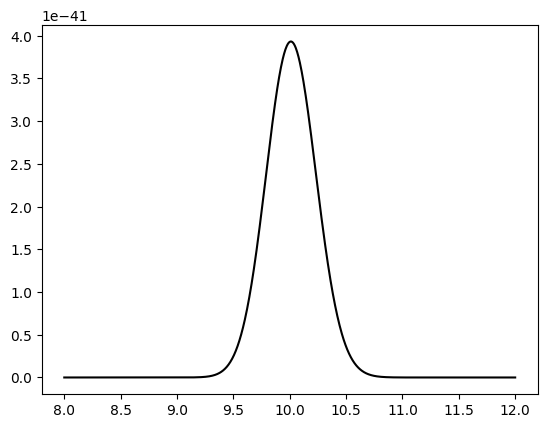

In [244]:
plt.figure()
plt.plot(a_values, P_values, "k-")
plt.show()

* Do the same computation but change the a_true to 0.5. What is the problem?
* What if we wanted to find the optimal value, i.e. where the maximum of the posterior is?

$$\large 
\frac{\partial}{\partial a} P(a | \{n_i\} \{s_i\}) = 0 
\Rightarrow 
\frac{\partial}{\partial a} P(a) \prod_{i=1}^{N} \dfrac{(a s_i)^{n_i} e^{-a s_i}}{n_i!} = 0 $$

# Working in log-space

When we are computing likelihoods and posteriors, we often explore regions where the model is improbable, and the quantities tend to zero. Also, with many data points, the product of the datum likelihoods becomes smaller and smaller, and often evaluates to zero!

In addition, differentiating the posterior (analytically or numerically) might be difficult if there is a significant peak.

Working in log-space alleviates all the above issues! The bell-like peaks become parbolas, the probabilities are now negative values with small absolute values. So the **log-posterior** is

$$\large
\ln \large P(a | \{n_i\} \{s_i\}) = \ln P(a) + \sum_{i=1}^{N} \ln L_i
$$

the sum of the **log-prior** and the **log-likelihood**, the latter being the sum of all **datum log-likelihoods**.

It's so useful, and more accurate to work in log-space, that most `scipy` statistical distributions have their log-analogs (e.g, `st.poisson.logpmf(...)`) that are optimized to give more accurate results than log-ing the original function.

Therefore, we can re-write the functions in their log-versions:

In [245]:
def ln_prior(scaling_factor):
    # return 0.0 if scaling_factor < 0 else 1.0
    return -np.inf if scaling_factor < 0 else 0.0

def datum_ln_likelihood(nulx, sfr, scaling_factor):
    # return st.poisson.pmf(nulx, sfr * scaling_factor)
    return st.poisson.logpmf(nulx, sfr * scaling_factor)

def ln_likelihood(nulx_array, sfr_array, scaling_factor):
    # return np.prod([datum_likelihood(nulx_i, sfr_i, scaling_factor) 
    #                for nulx_i, sfr_i in zip(nulx_array, sfr_array)])
    return np.sum([datum_ln_likelihood(nulx_i, sfr_i, scaling_factor)
                   for nulx_i, sfr_i in zip(nulx_array, sfr_array)])

def ln_posterior(scaling_factor):
    return ln_likelihood(n_ULXs, SFRs, scaling_factor) + ln_prior(scaling_factor)

lnP_values = np.array([ln_posterior(scaling_factor=a) for a in a_values])

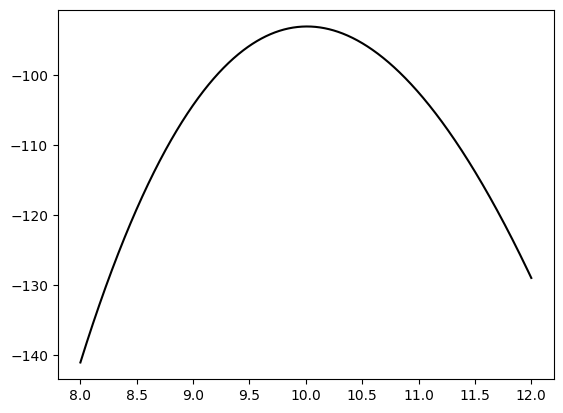

In [246]:
plt.figure()
plt.plot(a_values, lnP_values, "k-")
plt.show()

# Minimization as a means to get the Maximum a Posteriori (MAP) estimate

The parameter value at which the posterior is maximized is an estimate for the true value of the parameter. The maximum a posteriori estimate can be found using optimization techniques. Many algorithms have been implemented to do this for us (for example in the `scipy` package). Traditionally the search for the minimum in a function. Therefore, we proceed by negating the log-posterior. Let's try that!

In [247]:
def neg_ln_posterior(scaling_factor):
    return -ln_posterior(scaling_factor)

minimization_result = scipy.optimize.minimize(neg_ln_posterior,  x0=1.0)
print(f"MAP estimate for a = {minimization_result.x[0]:.4g}")
minimization_result

MAP estimate for a = 10.01


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 93.03659138444033
        x: [ 1.001e+01]
      nit: 11
      jac: [ 3.815e-06]
 hess_inv: [[ 4.874e-02]]
     nfev: 24
     njev: 12

# Getting the uncertainty on the parameter using the shape of the posterior

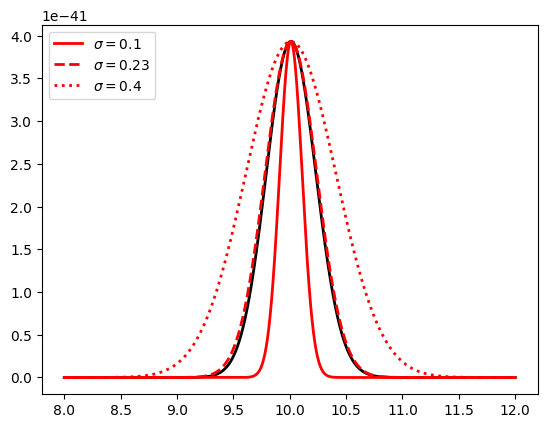

In [250]:
a_MAP = minimization_result.x[0]
P_at_a_MAP = posterior(a_MAP, nulx_array=n_ULXs, sfr_array=SFRs)
sigmas = [0.1, 0.23, 0.4]

plt.figure()
plt.plot(a_values, P_values, "k-", lw=2)
for sigma, ls in zip(sigmas, ["-", "--", ":"]):
    plt.plot(a_values, P_at_a_MAP * np.exp(-(a_values-a_MAP)**2.0 / (2*sigma**2.0)), "r", ls=ls, label=r"$\sigma=$"+f"{sigma:.3g}", lw=2)
plt.legend(loc="upper left")
plt.show()

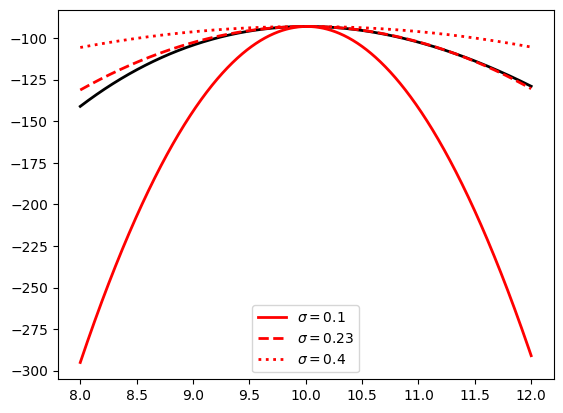

In [251]:
a_MAP = minimization_result.x[0]
lnP_at_a_MAP = ln_posterior(a_MAP)

plt.figure()
plt.plot(a_values, np.log(P_values), "k-", lw=2)
for sigma, ls in zip(sigmas, ["-", "--", ":"]):
    plt.plot(a_values, lnP_at_a_MAP - (a_values-a_MAP)**2.0 / (2*sigma**2.0), "r", ls=ls, label=r"$\sigma=$"+f"{sigma:.3g}", lw=2)
plt.legend(loc="lower center")
plt.show()

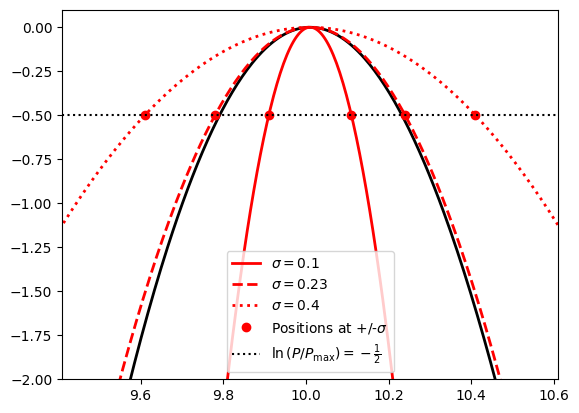

In [252]:
a_MAP = minimization_result.x[0]
lnP_at_a_MAP = ln_posterior(a_MAP)

plt.figure()
plt.plot(a_values, np.log(P_values) - lnP_at_a_MAP, "k-", lw=2)
for sigma, ls in zip(sigmas, ["-", "--", ":"]):
    plt.plot(a_values, -(a_values-a_MAP)**2.0 / (2*sigma**2.0), "r", ls=ls, label=r"$\sigma=$"+f"{sigma:.3g}", lw=2)
    for offset_in_sigmas in [-1, 1]:
        plt.plot(a_MAP + offset_in_sigmas * sigma, -(offset_in_sigmas * sigma)**2.0 / (2*sigma**2.0), "ro")
plt.plot([], [], "ro", label="Positions at +/-$\sigma$")
plt.axhline(-0.5, color="k", ls=":", label=r"$\ln\left(P / P_{\max}\right)=-\frac{1}{2}$")
plt.legend(loc="lower center")
plt.xlim(a_MAP - 0.6, a_MAP + 0.6)
plt.ylim(-2.0, 0.1)
plt.show()

MAP = 10.010 +/- 0.221 ... from the solutions: 9.791 and 10.232


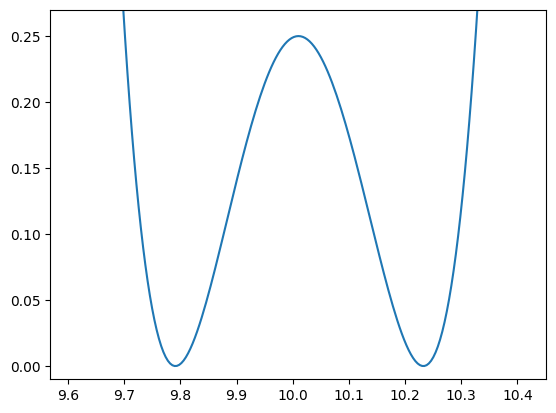

( message: Optimization terminated successfully
  success: True
   status: 0
      fun: 1.3494612540720524e-07
        x: [ 9.791e+00]
      nit: 15
      jac: [-3.380e-03]
     nfev: 30
     njev: 15,
  message: Optimization terminated successfully
  success: True
   status: 0
      fun: 9.914909001337087e-10
        x: [ 1.023e+01]
      nit: 12
      jac: [ 2.816e-04]
     nfev: 24
     njev: 12)

In [255]:
solution_left = scipy.optimize.minimize(lambda x: (ln_posterior(x) - lnP_at_a_MAP + 0.5)**2.0, x0=a_MAP / 2.0, method="SLSQP", bounds=[[0.0, a_MAP*0.999]])
solution_right = scipy.optimize.minimize(lambda x: (ln_posterior(x) - lnP_at_a_MAP + 0.5)**2.0, x0=a_MAP * 2.0, method="SLSQP", bounds=[[a_MAP*1.001, np.inf]])

a_lo = solution_left.x[0]
a_hi = solution_right.x[0]
a_err = (a_hi - a_lo) / 2.0
print(f"MAP = {a_MAP:.3f} +/- {a_err:.3f} ... from the solutions: {solution_left.x[0]:.3f} and {solution_right.x[0]:.3f}")

plt.figure()
xx = a_values
yy = [(ln_posterior(xxi) - lnP_at_a_MAP + 0.5)**2.0 for xxi in xx]
plt.plot(a_values, yy)
plt.xlim(a_MAP - 2*a_err, a_MAP + 2*a_err)
plt.ylim(-0.01, 0.27)
plt.show()

solution_left, solution_right

# References

[1] Vagshette et al. 2011, Proceedings of the 29th Meeting of the Astronomical Society of India, Chandra observation of NGC 1482.

[2] D. S. Sivia, J. Skilling (2006). Data Analysis: A Bayesian Tutorial. 2nd Edition. Oxford University Press.